## This section inculdes some helper functions needed in the notebook

In [1]:
def pre_process_image(img_path):
    normalization = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
    test_transform = transforms.Compose([
                                     transforms.RandomResizedCrop(224),

                                     transforms.ToTensor(),
                                     normalization])
    im = Image.open(img_path)
    input_tensor = test_transform(im)
    input_batch = input_tensor.unsqueeze(0)
    return input_batch

# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:

**Note: if you are using the Udacity workspace, you *DO NOT* need to re-download these - they can be found in the `/data` folder as noted in the cell below.**

* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [6]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 0 total human images.
There are 0 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

In [20]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [7]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
truly detected humans 0.98
dogs detected as humans 0.17

In [6]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
human_file_errors = 0
for human_file in human_files_short:
    if face_detector(human_file):
        human_file_errors += 1
human_file_accuracy = human_file_errors/100

dog_file_errors = 0
for dog_file in dog_files_short:
    if face_detector(dog_file):
        dog_file_errors += 1
dog_file_accuracy = dog_file_errors/100
print(f'truly detected humans {human_file_accuracy}')
print(f'dogs detected as humans {dog_file_accuracy}')

truly detected humans 0.98
dogs detected as humans 0.17


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [5]:
### (Optional) 
### TODO: Test performance of anotherface detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [8]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [9]:
from PIL import Image
import torchvision.transforms as transforms

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    
    input_batch = pre_process_image(img_path)
    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        VGG16.to('cuda')

    
    VGG16.eval()
    output = VGG16(input_batch)
    return  torch.argmax(output).item()# predicted class index

In [26]:
print(dog_files_short[0])
VGG16_predict(dog_files_short[0])

/data/dog_images/train/103.Mastiff/Mastiff_06833.jpg


243

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [10]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = VGG16_predict(img_path)
    if 151<= prediction <= 268:
        return True
    return False # true/false

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 
detected humans as dogs 0.0
detected dogs as dogs 0.99

In [12]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

human_file_errors = 0
for human_file in human_files_short:
    if dog_detector(human_file):
        human_file_errors += 1
human_file_accuracy = human_file_errors/100

dog_file_errors = 0
for dog_file in dog_files_short:
    if dog_detector(dog_file):
        dog_file_errors += 1
dog_file_accuracy = dog_file_errors/100
print(f'detected humans as dogs {human_file_accuracy}')
print(f'detected dogs as dogs {dog_file_accuracy}')

detected humans as dogs 0.01
detected dogs as dogs 0.93


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [11]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [12]:
import os
from torchvision import datasets

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
BATCH_SIZE = 20
transform = transforms.Compose([transforms.RandomResizedCrop(size=(256)),
    
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

test_transform = transforms.Compose([transforms.RandomResizedCrop(size=(256)),
   
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

dog_train_set = datasets.ImageFolder('/data/dog_images/train/',transform = transform)
dog_validation_set = datasets.ImageFolder('/data/dog_images/valid/',transform = test_transform)
dog_testing_set = datasets.ImageFolder('/data/dog_images/test/',transform = test_transform)

dog_train_loader = torch.utils.data.DataLoader(dog_train_set,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,
                                          num_workers=0)
dog_valid_loader = torch.utils.data.DataLoader(dog_validation_set,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,
                                          num_workers=0)
dog_test_loader = torch.utils.data.DataLoader(dog_testing_set,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,
                                          num_workers=0)
loaders_scratch = {'train':dog_train_loader,'valid':dog_valid_loader,'test':dog_test_loader}

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:
- The code resizes and crops the image randomly to the size of 256
- The images are normalized 
- I did Augment the images by :-
  - doing a random rotaion by 30 degrees
  - doing random horizontal flipping

### Visualizing batch of data

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

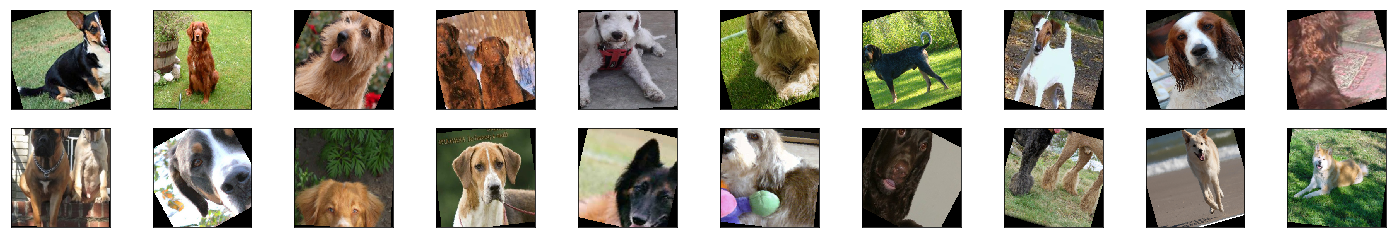

In [15]:
# obtain one batch of training images
dataiter = iter(dog_train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [14]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (128 * 16 * 16 -> 500)
        self.fc1 = nn.Linear(128 * 16 * 16, 1024)
        # linear layer (1024 -> 500)
        self.fc2 = nn.Linear(1024, 500)
        # linear layer (500 -> 133)# linear layer (500 -> 133)
        self.fc3 = nn.Linear(500, 133)
        # dropout layer (p=0.2)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        # flatten image input
        
        x = x.view(-1, 128 * 16 * 16)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 
My network has convolutional layers I started with :-
 - 3 RGB filters and got 16 filters 
 - then from the 16 filters we got 32 filters 
 - from the 32 filters we got 64 filters
 - from the 64 filters we got 128 filters 
 I applied RELU function and max pooling on each convolutional layer which resulted in an Image with `[128 * 16 * 16]` dimens
 I flattened the dimnens and applied 3 `Linear` functions:-
   - The first function we got 1024 output
   - The second fucntion we got 500 outputs
   - The third function we got 133 outputs (the number of dog breed classes

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [15]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch =  optim.SGD(model_scratch.parameters(), lr=0.1)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [33]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model.forward(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            if torch.isnan(loss.data):
                print('train nan')
                continue
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model.forward(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            if torch.isnan(loss.data):
                print('valid nan')
                continue
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
    # return trained model
    return model




In [20]:
# train the model
model_scratch = train(50, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 4.884295 	Validation Loss: 4.871405
Validation loss decreased (inf --> 4.871405).  Saving model ...
Epoch: 2 	Training Loss: 4.856527 	Validation Loss: 4.829204
Validation loss decreased (4.871405 --> 4.829204).  Saving model ...
Epoch: 3 	Training Loss: 4.794809 	Validation Loss: 4.761681
Validation loss decreased (4.829204 --> 4.761681).  Saving model ...
Epoch: 4 	Training Loss: 4.750708 	Validation Loss: 4.716914
Validation loss decreased (4.761681 --> 4.716914).  Saving model ...
Epoch: 5 	Training Loss: 4.679900 	Validation Loss: 4.619701
Validation loss decreased (4.716914 --> 4.619701).  Saving model ...
Epoch: 6 	Training Loss: 4.604836 	Validation Loss: 4.561727
Validation loss decreased (4.619701 --> 4.561727).  Saving model ...
Epoch: 7 	Training Loss: 4.546316 	Validation Loss: 4.536945
Validation loss decreased (4.561727 --> 4.536945).  Saving model ...
Epoch: 8 	Training Loss: 4.525733 	Validation Loss: 4.697450
Epoch: 9 	Training Loss: 4.476043 

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [16]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        if torch.isnan(loss.data):
            print('nan')
            continue
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    


In [17]:
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.551501


Test Accuracy: 16% (142/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [15]:
import torchvision.transforms as transforms# TODO: Specify data loaders
from torchvision import datasets
import torch
import torchvision.models as models

BATCH_SIZE = 20


normalization = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
transform = transforms.Compose([
                                     transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.RandomRotation(10),
                                     transforms.ToTensor(),
                                     normalization])


test_transform = transforms.Compose([transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalization])

dog_train_set = datasets.ImageFolder('/data/dog_images/train/',transform = transform)
dog_validation_set = datasets.ImageFolder('/data/dog_images/valid/',transform = test_transform)
dog_testing_set = datasets.ImageFolder('/data/dog_images/test/',transform = test_transform)



### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes





trainloader = torch.utils.data.DataLoader(dog_train_set, batch_size=32, shuffle=True)
validloader = torch.utils.data.DataLoader(dog_validation_set, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(dog_testing_set, batch_size=32, shuffle=True)

loaders_transfer = {'train':trainloader,'valid':validloader,'test':testloader}


FileNotFoundError: [WinError 3] The system cannot find the path specified: '/data/dog_images/train/'

In [28]:
print(loaders_transfer)

{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f9d056ebc50>, 'valid': <torch.utils.data.dataloader.DataLoader object at 0x7f9d056eb940>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f9d056eb9b0>}


### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [29]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 
use_cuda = torch.cuda.is_available()

model_transfer = models.resnet50(pretrained=True)
# Freeze training for all "features" layers

n_inputs = model_transfer.fc.in_features
# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, 133)
model_transfer.fc = last_layer


if use_cuda:
    model_transfer = model_transfer.cuda()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:04<00:00, 20872387.64it/s]


In [23]:
model_transfer

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 
- First I tried using VGG16 pretrained mode, but got very low accuracy
- I tried resenet50 and added to it a `Linear` Layer that got the number of features as input and returned `133` classes as output

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [30]:
import torch.optim as optim

criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.fc.parameters(), lr=0.1)

In [31]:
print(criterion_transfer)

CrossEntropyLoss()


### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [34]:
# train the model
model_transfer =  train(10, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)


Epoch: 1 	Training Loss: 2.817378 	Validation Loss: 1.040164
Validation loss decreased (inf --> 1.040164).  Saving model ...
Epoch: 2 	Training Loss: 1.439691 	Validation Loss: 0.733432
Validation loss decreased (1.040164 --> 0.733432).  Saving model ...
Epoch: 3 	Training Loss: 1.190531 	Validation Loss: 0.593912
Validation loss decreased (0.733432 --> 0.593912).  Saving model ...
Epoch: 4 	Training Loss: 1.068044 	Validation Loss: 0.593543
Validation loss decreased (0.593912 --> 0.593543).  Saving model ...
Epoch: 5 	Training Loss: 1.021296 	Validation Loss: 0.550115
Validation loss decreased (0.593543 --> 0.550115).  Saving model ...
Epoch: 6 	Training Loss: 0.955047 	Validation Loss: 0.494424
Validation loss decreased (0.550115 --> 0.494424).  Saving model ...
Epoch: 7 	Training Loss: 0.961281 	Validation Loss: 0.458939
Validation loss decreased (0.494424 --> 0.458939).  Saving model ...
Epoch: 8 	Training Loss: 0.920310 	Validation Loss: 0.492165
Epoch: 9 	Training Loss: 0.915062 

In [35]:
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [36]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.456214


Test Accuracy: 84% (707/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [14]:
from PIL import Image
import torchvision.models as models

### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in loaders_transfer['train'].dataset.classes]

def predict_breed_transfer(img_path,model):
    input_batch = pre_process_image(img_path) 
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')
    model.eval()
    output = model(input_batch)
    class_idx = torch.argmax(output).item()
    return class_names[class_idx]

NameError: name 'loaders_transfer' is not defined

In [38]:

for image_path in dog_files_short:
    print(image_path)
    print(predict_breed_transfer(image_path,model_transfer))
    
    

/data/dog_images/train/103.Mastiff/Mastiff_06833.jpg
Anatolian shepherd dog
/data/dog_images/train/103.Mastiff/Mastiff_06826.jpg
Mastiff
/data/dog_images/train/103.Mastiff/Mastiff_06871.jpg
Anatolian shepherd dog
/data/dog_images/train/103.Mastiff/Mastiff_06812.jpg
Chinese shar-pei
/data/dog_images/train/103.Mastiff/Mastiff_06831.jpg
Bullmastiff
/data/dog_images/train/103.Mastiff/Mastiff_06867.jpg
Mastiff
/data/dog_images/train/103.Mastiff/Mastiff_06845.jpg
Mastiff
/data/dog_images/train/103.Mastiff/Mastiff_06865.jpg
Bullmastiff
/data/dog_images/train/103.Mastiff/Mastiff_06866.jpg
Mastiff
/data/dog_images/train/103.Mastiff/Mastiff_06862.jpg
Mastiff
/data/dog_images/train/103.Mastiff/Mastiff_06853.jpg
Mastiff
/data/dog_images/train/103.Mastiff/Mastiff_06877.jpg
Mastiff
/data/dog_images/train/103.Mastiff/Mastiff_06839.jpg
Bullmastiff
/data/dog_images/train/103.Mastiff/Mastiff_06824.jpg
Bullmastiff
/data/dog_images/train/103.Mastiff/Mastiff_06814.jpg
Mastiff
/data/dog_images/train/103.Mas

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [5]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cbook as cbook
from PIL import Image
import cv2                
%matplotlib inline                               
def run_app(img_path):
    
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()
    if face_detector(img_path):
        print('Hello Human :')
        model = load_model()
        predicted_breed = predict_breed_transfer(img_path,model)
        print(f'{predicted_breed} looks a lot like you')
    ## handle cases for a human face, dog, and neither
    elif dog_detector(img_path):
        model = load_model()
        predicted_breed = predict_breed_transfer(img_path,model)
        print(f'this is a dog and it\'s breed is {predicted_breed} ')
    else:
        print('this is neither a dog nor a human')

In [4]:
import torchvision.models as models
import torch.nn as nn
def load_model():
    ## TODO: Specify model architecture 
    use_cuda = torch.cuda.is_available()

    model_transfer = models.resnet50(pretrained=True)
    # Freeze training for all "features" layers

    n_inputs = model_transfer.fc.in_features
    # new layers automatically have requires_grad = True
    last_layer = nn.Linear(n_inputs, 133)
    model_transfer.fc = last_layer


    if use_cuda:
        model_transfer = model_transfer.cuda()
    model_transfer.load_state_dict(torch.load('model_transfer.pt'))
    return model_transfer

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 
- The Ability to idnetifiy more than one breed in an Image
- The Ability to identify both humans and Dogs in an Image 
- The ability to identify more than one human in an Image
- The ability to differentiate between wolves and dogs

In [2]:
test_human_files = ['test_images/trump.jpg','test_images/mo.jpg','test_images/hp2.jpg','test_images/hp1.jpg','test_images/hp2.jpg']

test_dog_files= ['test_images/pb2.jpg','test_images/dog.jpg','test_images/wolf.jpg','test_images/human_dog.jpg']

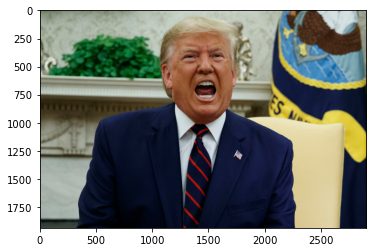

Hello Human :


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to C:\Users\a3ade/.cache\torch\hub\checkpoints\resnet50-19c8e357.pth


NameError: name 'predict_breed_transfer' is not defined

In [13]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
import numpy as np
for file in np.hstack((test_human_files[:4], test_dog_files[:4])):
    run_app(file)